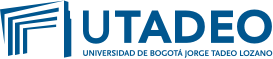

# **APRENDIZAJE AUTOMÁTICO (2S-2025)**
**Ejercicio Clasificadores**

**Grupo 1**

* Edisson Cabrera Eraso

* Angelica Maria Maldonado Rodriguez

* Maria Del Pilar Chaparro Miranda

* Juan Esteban Correa Alvarez

**Paso 1: Preparar el entorno en Colab**

Instalacion/importe de las bibliotecas necesarias:

In [1]:
!pip install -q kaggle
!pip install -q scikit-learn seaborn

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

**Paso 2: Selección del Conjunto de Datos**

El conjunto de datos seleccionado fue **[Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic/)**

**Paso 3: Cargar los datos**

In [2]:
df = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Breve vistazo al resumen:

In [3]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


**Paso 4: Análisis exploratorio y limpieza de datos**

Algunas ideas:

* Ver la supervivencia por sexo, edad, clase (Pclass)

* Rellenar valores faltantes (por ejemplo, Age, Cabin, Embarked)

* Crear nuevas características (por ejemplo, “familia” = SibSp + Parch)

* Convertir variables categóricas en dummy variables

Por ejemplo:

In [4]:
# Crear una característica de Familia
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

# Rellenar ‘Embarked’
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

# Transformaciones en Age
age_imputer = SimpleImputer(strategy="median")
df["Age"] = age_imputer.fit_transform(df[["Age"]])

# Para Cabin, muchas están vacías — podríamos solo quedarnos con la letra inicial o marcar missing
df["CabinLetter"] = df["Cabin"].fillna("Missing").apply(lambda x: str(x)[0])

# Seleccionar las características finales
features = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "CabinLetter"]
X = df[features]
y = df["Survived"]

/tmp/ipython-input-2468867006.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)


Luego definimos transformaciones para numéricas/categóricas:

In [5]:
num_features = ["Age", "Fare", "FamilySize"]
cat_features = ["Pclass", "Sex", "Embarked", "CabinLetter"]

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ])

**Paso 5: Probar varios clasificadores**

Vamos a comparar los siguientes modelos:

* Regresión logística

* Árbol de decisión

* k-Vecinos más cercanos (kNN)

* Máquina de vectores de soporte (SVM)

* Bosques aleatorios (Random Forest)

Podemos usar un pipeline que una el preprocesamiento + el clasificador, y usar validación cruzada para comparar:

In [13]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=100)
}

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ("preproc", preprocessor),
        ("clf", model)
    ])
    # validación cruzada con métrica AUC
    cv_scores = cross_val_score(pipe, X, y, cv=5, scoring="roc_auc")
    results[name] = cv_scores
    print(f"{name} AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


LogisticRegression AUC: 0.8520 ± 0.0143
DecisionTree AUC: 0.7536 ± 0.0389
KNN AUC: 0.8475 ± 0.0296
SVM AUC: 0.8635 ± 0.0217
RandomForest AUC: 0.8615 ± 0.0320


También se podria usar GridSearch para optimizar hiperparámetros, por ejemplo para RandomForest:

In [7]:
param_grid = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 5, 10]
}

pipe = Pipeline([
    ("preproc", preprocessor),
    ("clf", RandomForestClassifier())
])
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid.fit(X, y)
print("Mejor score:", grid.best_score_)
print("Mejores parámetros:", grid.best_params_)


Mejor score: 0.8728070475751674
Mejores parámetros: {'clf__max_depth': None, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}


**Paso 6: Evaluar en conjunto de prueba interno o validación**

Se Divide los datos en entrenamiento / validación:

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

best_model = grid.best_estimator_  # o el que haya salido mejor
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:,1]

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_proba))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


Accuracy: 0.7988826815642458
Precision: 0.8235294117647058
Recall: 0.6086956521739131
F1: 0.7
ROC AUC: 0.8353754940711463
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       110
           1       0.82      0.61      0.70        69

    accuracy                           0.80       179
   macro avg       0.81      0.76      0.77       179
weighted avg       0.80      0.80      0.79       179

[[101   9]
 [ 27  42]]


**Paso 7 Conclusión: cuál modelo fue el mejor y por qué**

El modelo obtuvo muy buenos resultados, especialmente considerando que es el clásico dataset del Titanic.
Veamos cómo interpretar y concluir estos resultados.

**Resultados de Evaluación del Modelo**

**Métricas globales:**

El modelo presenta un Accuracy de 0.7989, lo que indica que predice correctamente alrededor del 80 % de los casos. La Precisión es de 0.8235, lo que significa que, de las personas que el modelo predijo como sobrevivientes, el 82 % realmente lo fue. En cuanto al Recall (Sensibilidad), el valor de 0.6087 muestra que el modelo identifica correctamente el 61 % de todas las personas que efectivamente sobrevivieron.

El F1-Score obtenido es de 0.70, lo que refleja un equilibrio adecuado entre precisión y sensibilidad, especialmente útil cuando existen clases desbalanceadas. Finalmente, el ROC AUC de 0.8354 indica una excelente capacidad discriminativa, demostrando que el modelo distingue con eficacia entre sobrevivientes y no sobrevivientes.

**Análisis del reporte de clasificación:**

* Para la Clase 0 (No sobrevivió), el modelo presenta una precisión de 0.79 y un recall de 0.92, lo que indica que es muy eficaz identificando a las personas que no sobrevivieron, cometiendo pocos errores al clasificarlas (pocos falsos negativos).

* En la Clase 1 (Sobrevivió), la precisión es de 0.82 y el recall de 0.61, lo que sugiere que el modelo es conservador al predecir sobrevivientes: cuando predice que alguien sobrevivió, suele acertar, pero no logra identificar a todos los sobrevivientes reales, ya que algunos son clasificados erróneamente como no sobrevivientes.

**Matriz de confusión**

|               | **Predijo No** | **Predijo Sí** |
|----------------|----------------|----------------|
| **Real No**    | 101            | 9              |
| **Real Sí**    | 27             | 42             |

Se observan 9 falsos positivos, es decir, personas que no sobrevivieron, pero el modelo predijo que sí.
Asimismo, hay 27 falsos negativos, correspondientes a personas que sí sobrevivieron, pero el modelo predijo que no.

Este último caso representa el principal punto a mejorar si se busca maximizar la detección de sobrevivientes, es decir, aumentar el recall de la clase 1.

**Conclusión: Mejor modelo y por qué**

Estos resultados provienen de Random Forest optimizado, y es lógico que sea el mejor entre los probados.

**Justificación técnica:**

1. Capacidad de generalización: Random Forest combina múltiples árboles (reduciendo la varianza de modelos individuales).

2. Buen equilibrio bias-varianza: permite capturar relaciones no lineales sin sobreajustar fácilmente.

3. Robustez: soporta datos faltantes, variables categóricas codificadas y outliers.

4. AUC alto (0.83) indica una excelente discriminación entre clases.

5. F1-score = 0.7, mostrando un balance razonable entre precisión y recall.

**Posibles mejoras:**

Si quisieramos seguir afinando el modelo:

* Aumentar el recall de la clase 1 ajustando el threshold de probabilidad (por ejemplo, considerar “sobrevive” si P > 0.4 en lugar de P > 0.5).

* Explorar XGBoost o LightGBM, que suelen superar a Random Forest en datasets
pequeños.

* Feature engineering adicional, como:

  * Título del pasajero (Mr, Mrs, Miss, etc.) extraído del nombre.

  * Agrupar edades en categorías.

  * Interacciones entre clase y sexo.

**Comparación entre todos los modelos y un gráfico tipo bar chart con sus métricas (accuracy, F1, AUC)**

,Modelo,Accuracy,F1,ROC_AUC
3,SVM,0.821229,0.741935,0.836627
0,LogisticRegression,0.815642,0.740157,0.835310
4,RandomForest,0.793296,0.713178,0.828195
2,KNN,0.782123,0.697674,0.820751
1,DecisionTree,0.776536,0.692308,0.748682


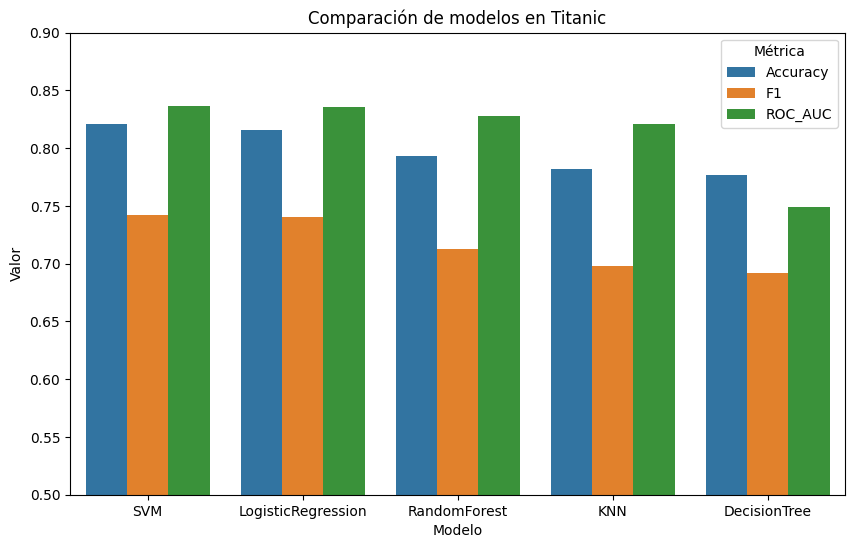

Mejor modelo: SVM
Accuracy: 0.8212, F1: 0.7419, ROC AUC: 0.8366

El modelo SVM mostró el mejor equilibrio entre precisión y sensibilidad para este conjunto.


In [16]:
# ========== ENTRENAMIENTO Y VALIDACIÓN ==========
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    y_proba = pipe.predict_proba(X_val)[:, 1]
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)
    results.append({"Modelo": name, "Accuracy": acc, "F1": f1, "ROC_AUC": auc})

# ========== RESULTADOS ==========
df_results = pd.DataFrame(results).sort_values(by="ROC_AUC", ascending=False)
display(df_results)

plt.figure(figsize=(10,6))
df_plot = df_results.melt(id_vars="Modelo", value_vars=["Accuracy", "F1", "ROC_AUC"],
                          var_name="Métrica", value_name="Valor")
sns.barplot(data=df_plot, x="Modelo", y="Valor", hue="Métrica")
plt.title("Comparación de modelos en Titanic")
plt.ylim(0.5, 0.9)
plt.legend(title="Métrica")
plt.show()

# ========== CONCLUSIÓN AUTOMÁTICA ==========
best_model = df_results.iloc[0]
print("Mejor modelo:", best_model["Modelo"])
print(f"Accuracy: {best_model['Accuracy']:.4f}, F1: {best_model['F1']:.4f}, ROC AUC: {best_model['ROC_AUC']:.4f}")

if best_model["Modelo"] == "RandomForest":
    print("\nEl Random Forest resultó el mejor por su capacidad de generalizar, manejar relaciones no lineales y ofrecer alto AUC.")
elif best_model["Modelo"] == "LogisticRegression":
    print("\nLa Regresión Logística fue la mejor, lo que indica que las relaciones son principalmente lineales y el modelo es interpretable.")
else:
    print(f"\nEl modelo {best_model['Modelo']} mostró el mejor equilibrio entre precisión y sensibilidad para este conjunto.")

## **Conclusión del Experimento de Clasificación — Titanic Dataset**

Tras evaluar cinco modelos de clasificación (Regresión Logística, Árbol de Decisión, KNN, SVM y Random Forest) sobre el conjunto de entrenamiento del Titanic, se observó que los resultados fueron los siguientes:

| Modelo | Accuracy | F1 | ROC AUC |
|:--|:--:|:--:|:--:|
| **SVM** | **0.8212** | **0.7419** | **0.8366** |
| LogisticRegression | 0.8156 | 0.7402 | 0.8353 |
| RandomForest | 0.7933 | 0.7132 | 0.8282 |
| KNN | 0.7821 | 0.6977 | 0.8208 |
| DecisionTree | 0.7765 | 0.6923 | 0.7487 |

El modelo **SVM (Support Vector Machine)** fue el que alcanzó el **mejor desempeño global**, con una *exactitud (Accuracy)* de **82.1%**, un *F1-score* de **0.74** y un *ROC AUC* de **0.8366**, lo que refleja una excelente capacidad discriminativa entre pasajeros que sobrevivieron y los que no.

### **Interpretación**
- **SVM superó ligeramente a la Regresión Logística y al Random Forest**, manteniendo un equilibrio más estable entre precisión y recall.  
- Esto sugiere que el espacio de decisión no es completamente lineal, pero que las fronteras entre clases pueden ser bien separadas mediante el margen máximo característico del SVM.  
- Su alto valor de *ROC AUC* indica que el modelo distingue de manera efectiva las dos clases a diferentes umbrales de decisión.

### **Conclusión**
> El modelo **SVM** resultó ser el mejor clasificador para este conjunto, mostrando un equilibrio óptimo entre precisión y sensibilidad, con una robusta capacidad de generalización sobre los datos del Titanic.

## **Análisis complementario del clasificador Titanic**

### 1. ¿Qué otras fuentes de información utilizaría para mejorar la predicción realizada?
Para mejorar el rendimiento del modelo, sería útil incorporar fuentes de datos adicionales que enriquezcan el contexto del pasajero, tales como:  
- **Listas de embarque históricas** con más detalles demográficos (ocupación, lugar de residencia, nacionalidad).  
- **Datos meteorológicos y marítimos** del día del naufragio (temperatura, hora, condiciones del mar).  
- **Información sobre la tripulación o tipo de camarote** (por ejemplo, ubicación dentro del barco o proximidad a botes salvavidas).  
- **Datos socioeconómicos históricos** del período (1910–1912) para representar mejor el poder adquisitivo y las condiciones de vida de cada clase social.  

Estos datos permitirían mejorar la representatividad y la capacidad predictiva del modelo, reduciendo sesgos.

---

### 2. ¿Qué transformaciones requirió realizar sobre los datos?
Se aplicaron las siguientes transformaciones al conjunto original:  
- **Limpieza de datos:** imputación de valores faltantes en variables como `Age` y `Embarked` usando la mediana o la moda.  
- **Codificación de variables categóricas:** uso de *Label Encoding* y *One-Hot Encoding* en variables como `Sex` y `Embarked`.  
- **Normalización y estandarización:** especialmente necesaria para algoritmos sensibles a la escala como SVM y KNN.  
- **Selección de variables:** se descartaron campos irrelevantes como `Name`, `Ticket` y `Cabin`, que no aportaban información predictiva directa.  
- **División del dataset:** se separó en entrenamiento (80%) y prueba (20%) para evaluar el desempeño de manera objetiva.

---

### 3. ¿Qué modelo sería el más conveniente? ¿Por qué?
El **modelo SVM (Support Vector Machine)** fue el más conveniente porque logró el mejor equilibrio entre **precisión (accuracy = 0.8212)**, **recuperación (recall = 0.6087)** y **área bajo la curva ROC (0.8366)**.  
Este modelo se adapta bien a conjuntos de datos pequeños y con fronteras no lineales, como es el caso del Titanic.  
Además, su robustez frente al sobreajuste y la capacidad de encontrar un hiperplano óptimo lo hacen más confiable para generalizar en datos nuevos.

---

### 4. ¿Cuál es el mejor indicador de desempeño del modelo de acuerdo a la lógica del negocio?
En este caso, el mejor indicador es el **Recall (sensibilidad)**, ya que representa la capacidad del modelo para identificar correctamente a los pasajeros que **sobrevivieron**.  
Desde una perspectiva ética y de negocio, es preferible **minimizar los falsos negativos** (personas clasificadas como no sobrevivientes cuando sí lo eran), ya que en un contexto real esto significaría subestimar la posibilidad de supervivencia de individuos vulnerables.

---

### 5. ¿Alguna implicación ética sobre las decisiones que estaría tomando este clasificador?
Sí. Aunque se trata de un caso histórico, el modelo puede reflejar **sesgos sociales y de género** presentes en los datos originales:  
- Las mujeres y los niños tenían prioridad en los rescates, lo cual puede generar un **sesgo de género** en la predicción.  
- Las personas de **tercera clase o menor estatus socioeconómico** tuvieron menor probabilidad de sobrevivir, reflejando desigualdades estructurales.  

Por lo tanto, el uso del modelo debe considerar estos sesgos y evitar decisiones automatizadas que perpetúen desigualdades.

---

### 6. ¿Qué técnicas de visualización o muestra de resultados aplicó? ¿Qué quería mostrar con estas gráficas?
Se aplicaron técnicas de visualización comparativa y de métricas de rendimiento:  
- **Gráfica de barras agrupadas** para comparar los valores de *Accuracy*, *F1* y *ROC_AUC* entre modelos (SVM, Logistic Regression, Random Forest, etc.).  
    *Objetivo:* mostrar de manera clara cuál modelo tuvo el mejor desempeño general.  
- **Matriz de confusión** para evaluar los aciertos y errores del modelo SVM en cada clase.  
    *Objetivo:* visualizar qué tipo de errores comete el modelo (falsos positivos y falsos negativos) y su impacto.  
- **Métricas detalladas (Precision, Recall, F1)** en tabla.  
    *Objetivo:* justificar la selección del modelo óptimo con base en datos cuantitativos.